## Introduction
In this notebook I'll introduce my results in a super resolution exercise.
Our goal is to reverse a given picture in a low resultion into higher resultion.

Some of the learning methods this exercise will introduce are _residual blocks_, _transfer learning_, _dilated convolution_ etc.

The data set we used is from the PASCAL Visual Object Classes Challenge 2007 of kaggle.

In [1]:
%pip install --user opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git https://github.com/titu1994/keras-efficientnets.git

     - 133kB 357kB/s
  ERROR: Cannot unpack file /tmp/pip-unpack-lw0u89xm/keras-efficientnets.git (downloaded from /tmp/pip-req-build-1pte3e9o, content-type: text/html; charset=utf-8); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-1pte3e9o
Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
import numpy as np
from keras.models import Model
from keras.applications.vgg16 import VGG16
import keras.backend as K
import tensorflow as tf
import gc
import cv2
import pandas as pd
from keras.models import model_from_json
from os import listdir
from os.path import join
import os
class LeakyRELU(LeakyReLU):
    def __init__(self, **kwargs):
        self.__name__ = "LeakyRELU"
        super(LeakyRELU, self).__init__(**kwargs)

Using TensorFlow backend.


### Data Pre-Process
Our data consists of 5011 in different shapes. We are interested in creating data set <X,Y> such that X shape is `(72,72,3)`, `Y[0]` shape is  `(144,144,3)` and `Y[1]` shape is  `(288,288,3)`. In order to make our preprocess comfortable and efficient we'll use the lazy data structure _Generator_

In [2]:
# Some sampling from the data shapes
images = []
for im in listdir('first_20'):
    images.append(cv2.imread('first_20/{}'.format(im)))
print(images[0].shape,images[1].shape, images[10].shape)

(375, 500, 3) (333, 500, 3) (500, 334, 3)


In [3]:
train_dir = 'VOCdevkit_v2/VOC2007/JPEGImages/train'
val_dir = 'VOCdevkit_v2/VOC2007/JPEGImages/val'
inp_shape = (72,72,3)

In [4]:
#Our memmory friendly generator
class MyGen(object):
    def __init__(self, pti):
        self._pti = pti
    def __iter__(self):
        i=0
        x = []
        y_144 = []
        y_288 = []
        for file in os.listdir(self._pti):
            im = cv2.imread(os.path.join(self._pti, file))
            if im is not None:
                im = im/255. ##normalizing the picture
                x.append(cv2.resize(im, (72,72,)))
                y_144.append(cv2.resize(im, (144,144,)))
                y_288.append(cv2.resize(im, (288,288,)))
                i+=1 
            if i % 32 ==0:
                yield (np.array(x), [np.array(y_144),np.array(y_288)])
                x = []
                y_144 = []
                y_288 = []

                
                
class TrainGen(MyGen):
    def __init__(self):
        super(TrainGen, self).__init__(train_dir)
class ValGen(MyGen):
    def __init__(self):
        super(ValGen, self).__init__(val_dir)

In [7]:
images = list(
    map(
        lambda x: x/255,
        images
    )
)

In [8]:
im_72 = list(
    map(
        lambda x: cv2.resize(x,(72,72)),
        images
    )
)
im_144 = list(
    map(
        lambda x: cv2.resize(x,(144,144)),
        images
    )
)
im_288 = list(
    map(
        lambda x: cv2.resize(x,(288,288)),
        images
    )
)


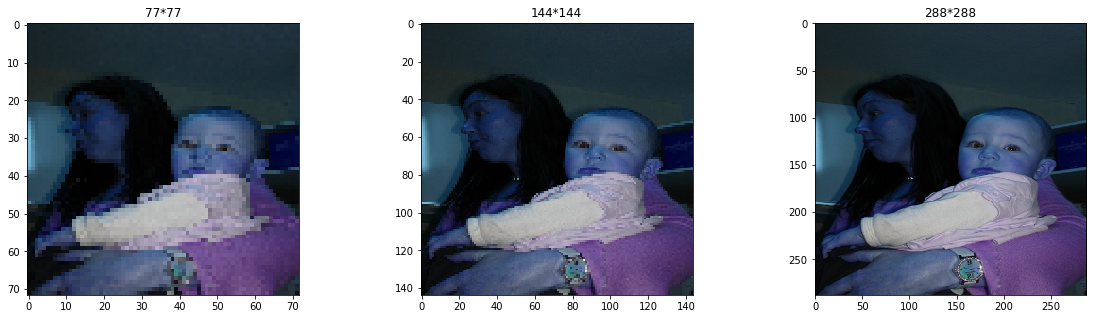

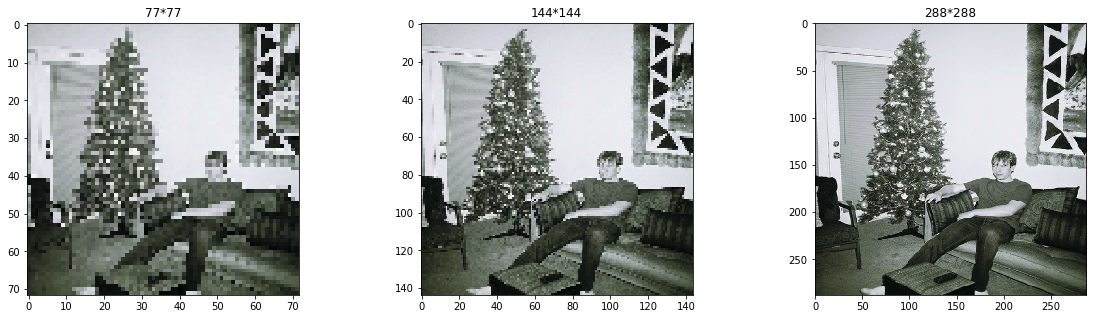

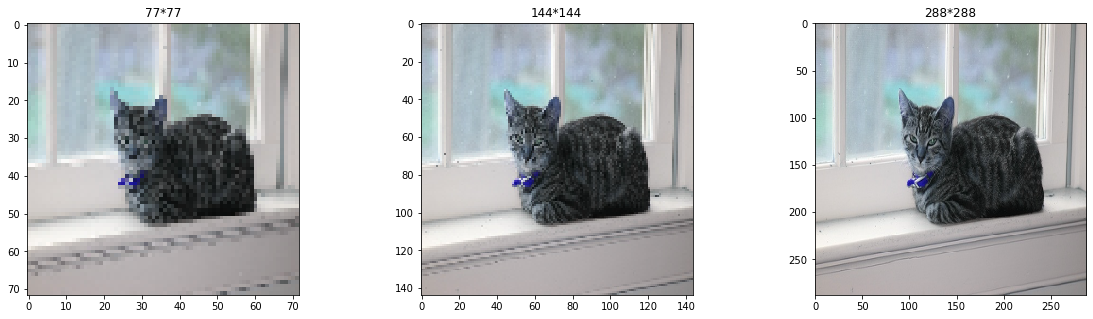

In [5]:
#Checking our validation data
val_batch = next(ValGen().__iter__())


for some_index in [0, 8 , 30]:
    _, ax = plt.subplots(1,3, figsize =(20,5))
    ax[0].imshow(val_batch[0][some_index])
    ax[0].set_title("77*77")
    ax[1].imshow(val_batch[1][0][some_index])
    ax[1].set_title("144*144")
    ax[2].imshow(val_batch[1][1][some_index])
    ax[2].set_title("288*288")

### First Model
Our first model will be the simplest. We'll use two conolutional layers, keeping the our original horizontal and vertical dimension. We then upsample once for the 144\*144 output and twice for the 288\*288 output.

In [6]:
def train_model(model):
    return model.fit_generator(
        TrainGen().__iter__(),
        steps_per_epoch=10,
        validation_data = ValGen().__iter__(),
        validation_steps = 1,
        epochs = 5
    )
        

In [7]:
def show_learning_history(history):
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    # Plot training & validation loss values
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [74]:
def examine_model(idx, x, y_144,y_288, model):
    f_orig, axarr_orig = plt.subplots(1,1, figsize = (5,5), )
    axarr_orig.imshow(
        x[idx]
    )
    axarr_orig.set_title("orig 72*72")
    
    f, axarr = plt.subplots(2,2, figsize = (10,10))
    
    axarr[0][0].imshow(
        y_144[idx]
    )
    axarr[0][0].set_title("orig 144*144")
    axarr[0][1].imshow(
        model.predict(np.expand_dims(x[idx], axis = 0))[0][0]
    )
    axarr[0][1].set_title("pred 144*144")
    
    axarr[1][0].imshow(
        y_288[idx]
    )
    axarr[1][0].set_title("orig 288*288")
    axarr[1][1].imshow(
        model.predict(np.expand_dims(x[idx], axis = 0))[1][0]
    )
    axarr[1][1].set_title("pred 288*288")

In [9]:
def create_simple_model():
    inp = Input(shape=(72,72,3))
    x = Conv2D(64, 3, padding = 'same')(inp)
    x = Conv2D(64, 3,padding = 'same')(x)
    x_144 = UpSampling2D(size = (2,2))(x)
    x_288 = UpSampling2D(size = (4,4))(x)
    x_144 =Conv2D(3 ,1)(x_144)
    x_288 =Conv2D(3 ,1)(x_288)
    return Model(inp, [x_144,x_288])

In [120]:
model = create_simple_model()
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()
h = train_model(model)

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 72, 72, 64)   1792        input_29[0][0]                   
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 72, 72, 64)   36928       conv2d_78[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_23 (UpSampling2D) (None, 144, 144, 64) 0           conv2d_79[0][0]                  
___________________________________________________________________________________________

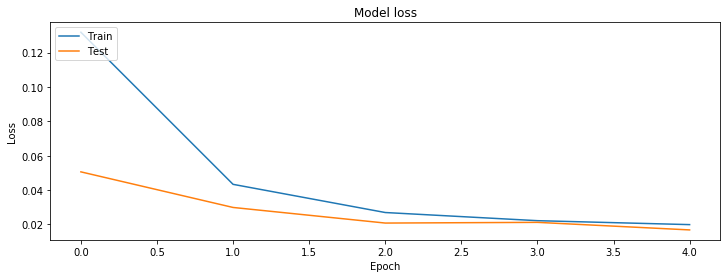

In [121]:
show_learning_history(h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


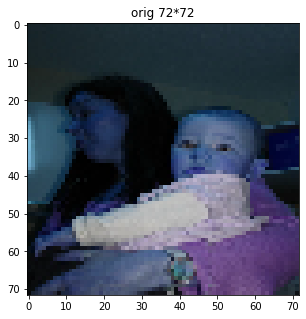

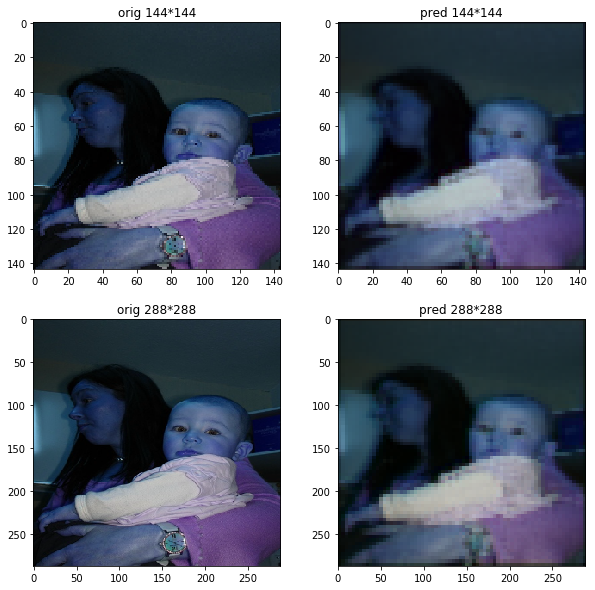

In [124]:
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = model
)

### Residual blocks
Our next strategy is going to be residual blocks, with an hope that our model will learn if some block of layers improves our results.
Our residual block can be visualized like this:

<img src="markdown/res_block.png">

And our whole model, shall look as follow:

<img src="markdown/res_block_model.png">

In [10]:
def res_block():
    inp = Input(shape = (None, None, 64))
    x = Conv2D(64, 3, activation=LeakyRELU(alpha = 0.2), padding = 'same')(inp)
    x = Conv2D(64, 3, activation=LeakyRELU(alpha = 0.2), padding = 'same')(x)
    x = add([x, inp])
    x = Activation(LeakyRELU(alpha = 0.2))(x)
    return Model(inp, x)
    

In [11]:
def create_res_block_model(weights = None):    
    inp = Input(shape = (72,72,3))
    x = Conv2D(64,1)(inp)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x_144 = UpSampling2D(size = (2,2))(x)
    x_288 = UpSampling2D(size = (4,4))(x)
    x_144 =Conv2D(3 ,1)(x_144)
    x_288 =Conv2D(3 ,1)(x_288)
    model = Model(inp, [x_144,x_288])
    if weights is None:
        return model
    else:
        model.load_weights(weights)
        return model

In [11]:
res_block_model = create_res_block_model()
res_block_model.compile(optimizer = 'adam', loss = 'mse')
res_block_model.summary()
h = train_model(res_block_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/rotba/.local/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyRELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 multiple             73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
model_2 (Model)                 multiple             73856       model_1[1][0]                    
____________________________________________________________________________________________

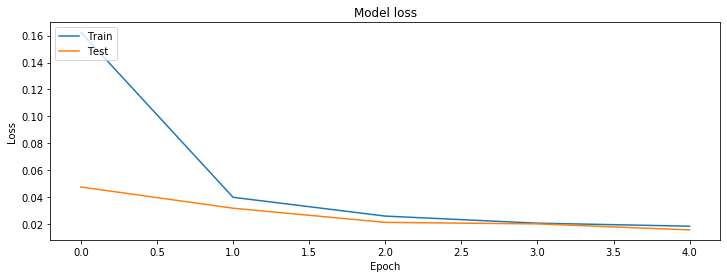

In [13]:
show_learning_history(h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


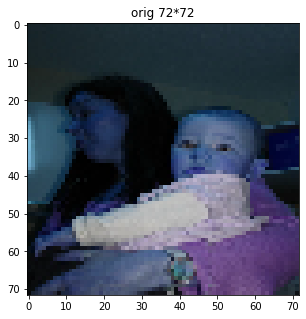

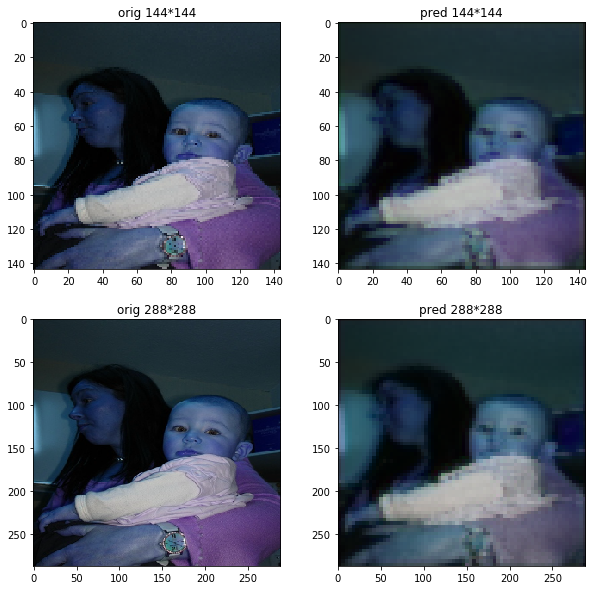

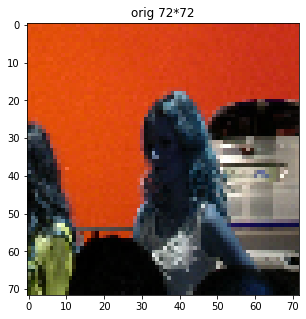

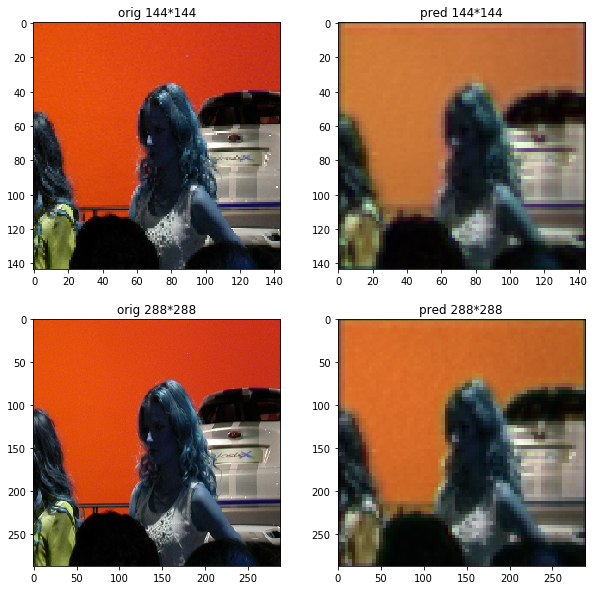

In [17]:
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = res_block_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = res_block_model
)

### Dilated residual blocks
We are tying this model with a sense that maybe it is "informable" to infere conclusion about a pixel taking into account not only it's adjecent neighbours but some of his neighbours of his neighbours. We will add 3 residual blocks withs 1 2 and four dialation rate.
<img src="markdown/dilated_res.png">

In [18]:
def res_dialted_block():
    inp = Input(shape=(None,None,32))
    d1 = Conv2D(32, 3, padding='same', activation='relu', dilation_rate=1)(inp)
    d2 = Conv2D(32, 3, padding='same', activation='relu', dilation_rate=2)(inp)
    d4 = Conv2D(32, 3, padding='same', activation='relu', dilation_rate=4)(inp)
    x = Concatenate()([d1, d2, d4])
    x = Conv2D(32,1)(x)
    x = Add()([x , inp])
    x = Activation(LeakyRELU())(x)
    return Model(inp,x)

def create_dilated_model():
    inp = Input(shape = (72,72,3))
    x = Conv2D(32,1 , padding='same', activation='relu')(inp)
    x = res_dialted_block()(x)
    x = res_dialted_block()(x)
    x = UpSampling2D()(x)
    x_144 = Conv2D(3,(1,1),activation='relu')(x)
    x_288 = res_dialted_block()(x)
    x_288 = UpSampling2D()(x_288)
    x_288 = Conv2D(3,(1,1),activation='relu')(x_288)
    return Model(inp, [x_144,x_288])

In [19]:
model = create_dilated_model()
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()
h = train_model(model)

/home/rotba/.local/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyRELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 72, 72, 32)   128         input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 multiple             30848       conv2d_14[0][0]                  
__________________________________________________________________________________________________
model_3 (Model)                 multiple             30848       model_2[1][0]                    
____________________________________________________________________________________________

In [21]:
dilated_model = model

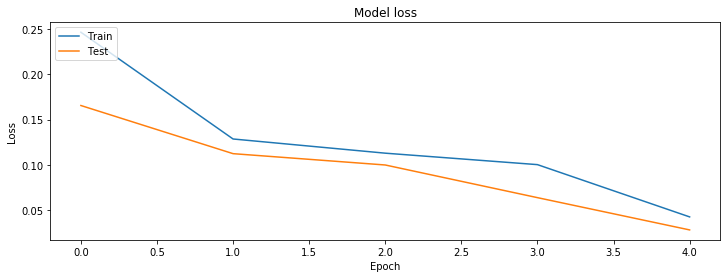

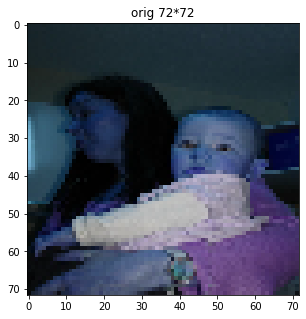

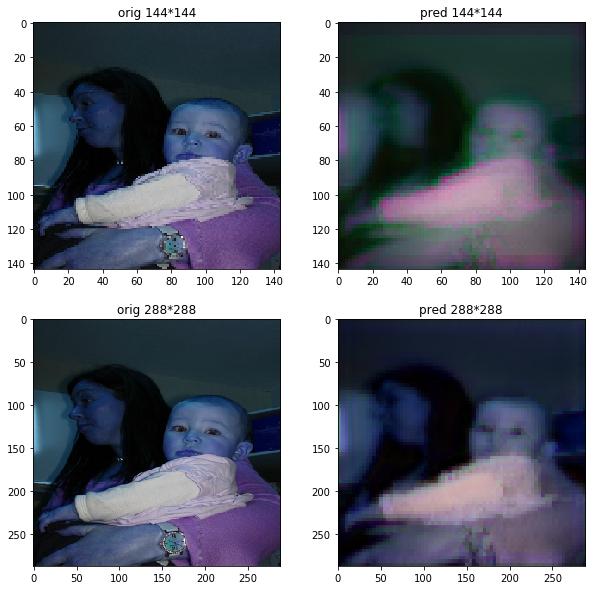

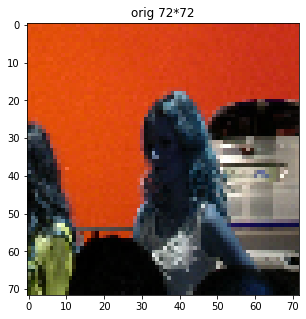

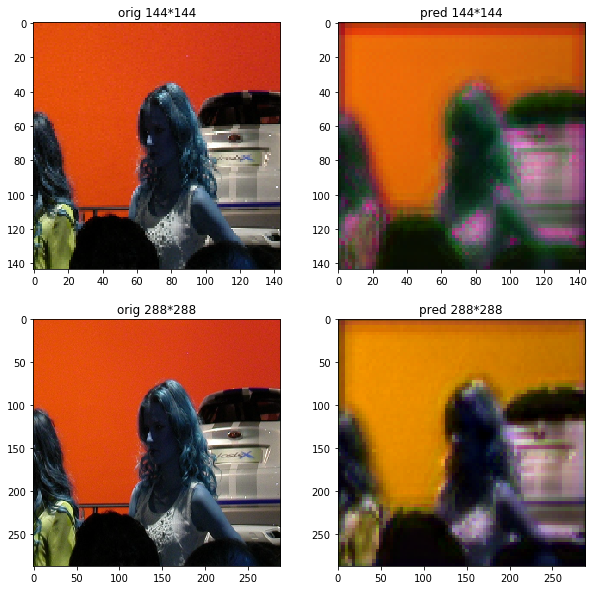

In [22]:
show_learning_history(h)
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = dilated_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = dilated_model
)

We can see that in this  model the model didn't overfit quickly to the training set. So we we'll give it some more epoches.

In [23]:
h = train_model(dilated_model)

Epoch 1/5
10/10 [==============================] - 45s 5s/step - loss: 0.0277 - conv2d_23_loss: 0.0166 - conv2d_28_loss: 0.0110 - val_loss: 0.0206 - val_conv2d_23_loss: 0.0113 - val_conv2d_28_loss: 0.0094
Epoch 2/5
10/10 [==============================] - 38s 4s/step - loss: 0.0224 - conv2d_23_loss: 0.0123 - conv2d_28_loss: 0.0101 - val_loss: 0.0218 - val_conv2d_23_loss: 0.0114 - val_conv2d_28_loss: 0.0104
Epoch 3/5
10/10 [==============================] - 38s 4s/step - loss: 0.0181 - conv2d_23_loss: 0.0096 - conv2d_28_loss: 0.0086 - val_loss: 0.0164 - val_conv2d_23_loss: 0.0086 - val_conv2d_28_loss: 0.0078
Epoch 4/5
10/10 [==============================] - 38s 4s/step - loss: 0.0175 - conv2d_23_loss: 0.0092 - conv2d_28_loss: 0.0083 - val_loss: 0.0184 - val_conv2d_23_loss: 0.0096 - val_conv2d_28_loss: 0.0087
Epoch 5/5
10/10 [==============================] - 38s 4s/step - loss: 0.0168 - conv2d_23_loss: 0.0088 - conv2d_28_loss: 0.0080 - val_loss: 0.0146 - val_conv2d_23_loss: 0.0076 - va

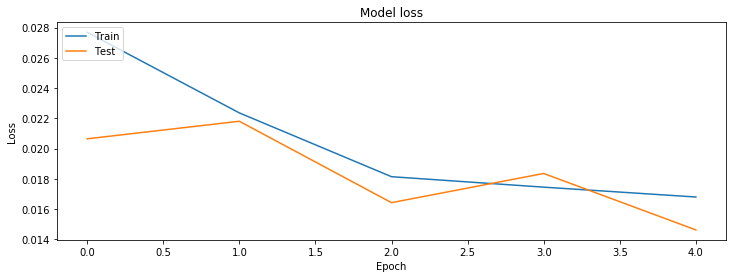

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


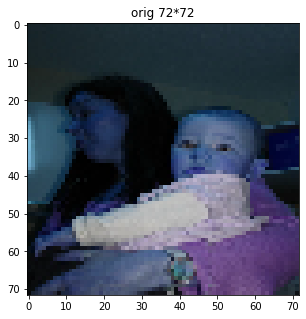

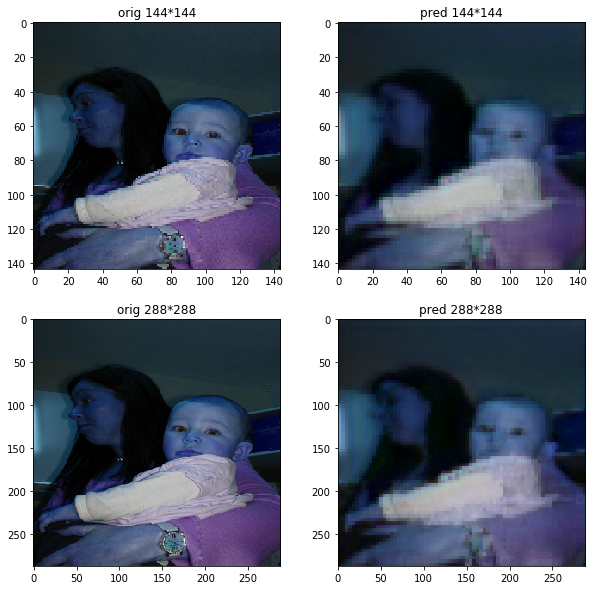

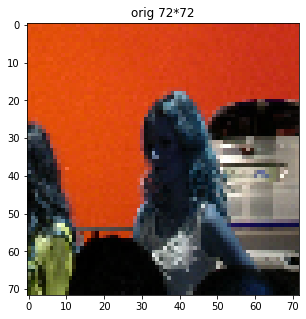

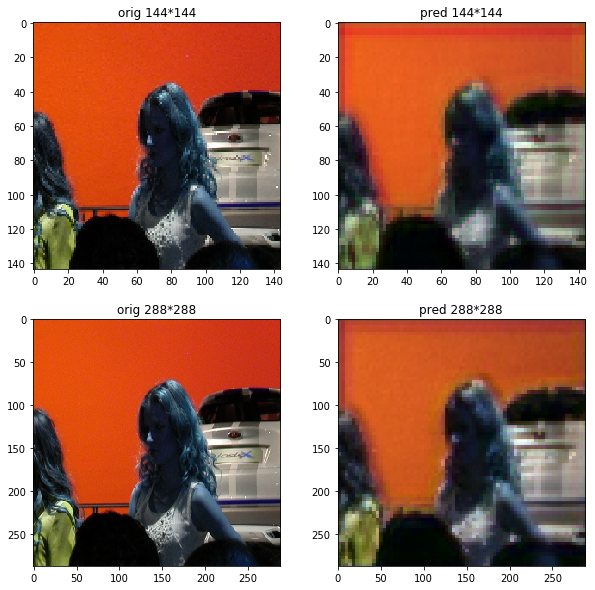

In [26]:
show_learning_history(h)
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = dilated_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = dilated_model
)

### Using pretrained model
We will use VGG16 as a feature extractor to our model

In [31]:
def create_vgg_model():
    VGG16(include_top =False).get_layer("block1_conv2")
    inp = Input(shape = (72,72,3))
    x = Conv2D(kernel_size = 1,filters = 64)(inp)
    x = VGG16(include_top =False).get_layer("block1_conv2")(x)
    x = concatenate([inp,x])
    x = Conv2D(64, 3, padding = 'same')(inp)
    x = Conv2D(64, 3,padding = 'same')(x)
    x_144 = UpSampling2D(size = (2,2))(x)
    x_288 = UpSampling2D(size = (4,4))(x)
    x_144 =Conv2D(3 ,1)(x_144)
    x_288 =Conv2D(3 ,1)(x_288)
    model = Model(inp, [x_144,x_288])
    return model

In [32]:
pre_trained_model = create_vgg_model()
pre_trained_model.compile(optimizer = 'adam', loss = 'mse')
pre_trained_model.summary()
h = train_model(pre_trained_model)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 72, 72, 64)   1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 72, 72, 64)   36928       conv2d_30[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, 144, 144, 64) 0           conv2d_31[0][0]                  
____________________________________________________________________________________________

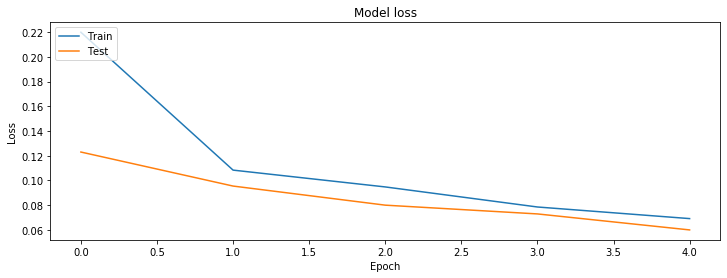

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


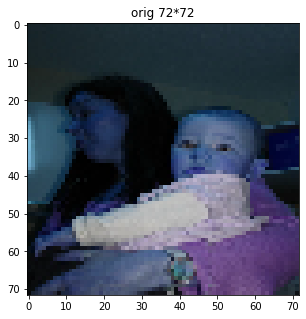

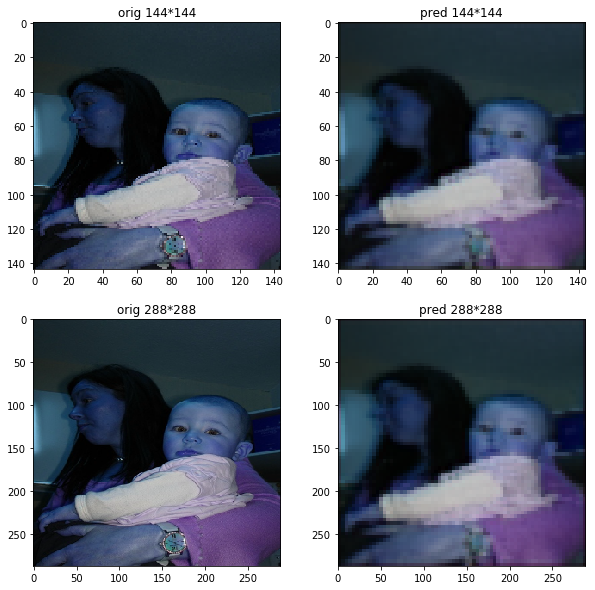

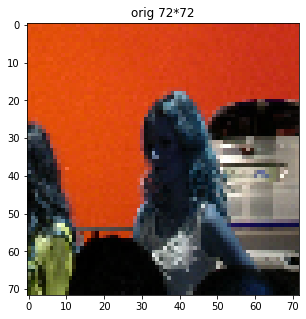

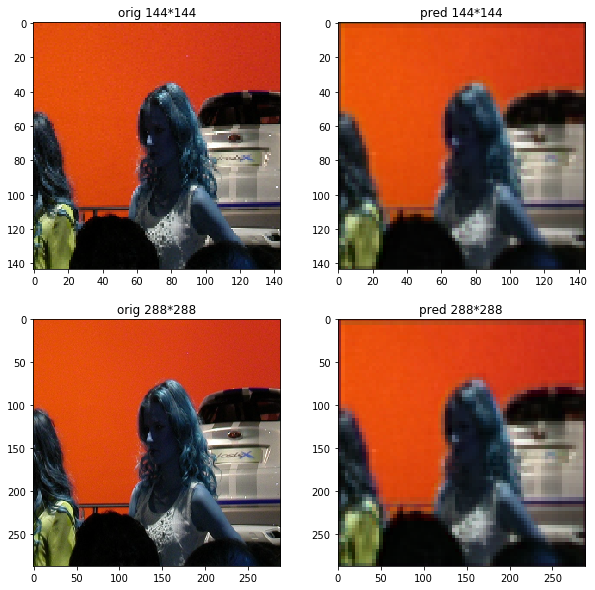

In [76]:
show_learning_history(h)
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = pre_trained_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = pre_trained_model
)

In [71]:
val_batch[1][0][1].shape

(144, 144, 3)

In [37]:
train_model(pre_trained_model)

Epoch 1/5
10/10 [==============================] - 19s 2s/step - loss: 0.0195 - conv2d_32_loss: 0.0099 - conv2d_33_loss: 0.0096 - val_loss: 0.0172 - val_conv2d_32_loss: 0.0087 - val_conv2d_33_loss: 0.0085
Epoch 2/5
10/10 [==============================] - 15s 2s/step - loss: 0.0189 - conv2d_32_loss: 0.0096 - conv2d_33_loss: 0.0093 - val_loss: 0.0203 - val_conv2d_32_loss: 0.0103 - val_conv2d_33_loss: 0.0100
Epoch 3/5
10/10 [==============================] - 14s 1s/step - loss: 0.0170 - conv2d_32_loss: 0.0086 - conv2d_33_loss: 0.0084 - val_loss: 0.0154 - val_conv2d_32_loss: 0.0078 - val_conv2d_33_loss: 0.0077
Epoch 4/5
10/10 [==============================] - 14s 1s/step - loss: 0.0173 - conv2d_32_loss: 0.0088 - conv2d_33_loss: 0.0086 - val_loss: 0.0184 - val_conv2d_32_loss: 0.0093 - val_conv2d_33_loss: 0.0090
Epoch 5/5
10/10 [==============================] - 14s 1s/step - loss: 0.0171 - conv2d_32_loss: 0.0086 - conv2d_33_loss: 0.0084 - val_loss: 0.0149 - val_conv2d_32_loss: 0.0075 - va

In [39]:
pre_trained_model.save_weights(join("models", "vgg.h5"))

### Depth to space
In this approach we're trying to use the number of features maps in one of our layers, hoping that it will reflect in a good way in the spacial dimension

In [65]:
def create_d2pace_model():
    inp = Input(shape = (72,72,3))
    x = Conv2D(64,1, activation=LeakyRELU(alpha = 0.2))(inp)
    x = Activation(LeakyRELU(alpha = 0.2))(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = res_block()(x)
    x = Activation(LeakyRELU(alpha = 0.2))(x)
    x_144 = Lambda(lambda x: tf.depth_to_space(input=x,block_size=2))(x)
    x_144 = Activation(LeakyRELU(alpha = 0.2))(x_144)
    x_288 =Lambda(lambda x: tf.depth_to_space(input=x,block_size=2,))(x_144)
    x_288 = Activation(LeakyRELU(alpha = 0.2))(x_288)
    x_144 =Conv2D(3 ,1, activation=LeakyRELU(alpha = 0.2))(x_144)
    x_288 = Conv2D(3 ,1, activation=LeakyRELU(alpha = 0.2))(x_288)
    return Model(inp, [x_144,x_288])

In [66]:
d2space_model = create_d2pace_model()
d2space_model.compile(optimizer = 'adam', loss = 'mse')
d2space_model.summary()
h = train_model(d2space_model)

Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 72, 72, 64)   256         input_91[0][0]                   
__________________________________________________________________________________________________
activation_103 (Activation)     (None, 72, 72, 64)   0           conv2d_182[0][0]                 
__________________________________________________________________________________________________
model_79 (Model)                multiple             73856       activation_103[0][0]             
___________________________________________________________________________________________

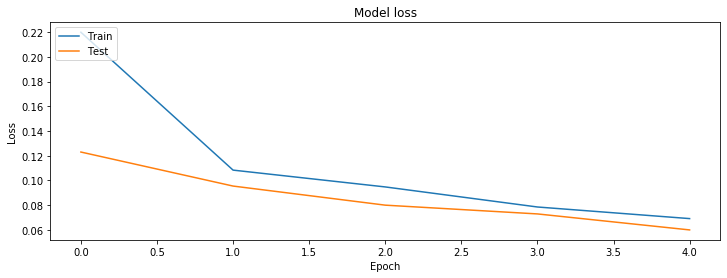

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


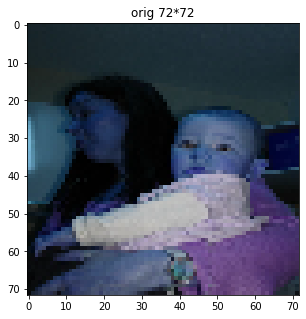

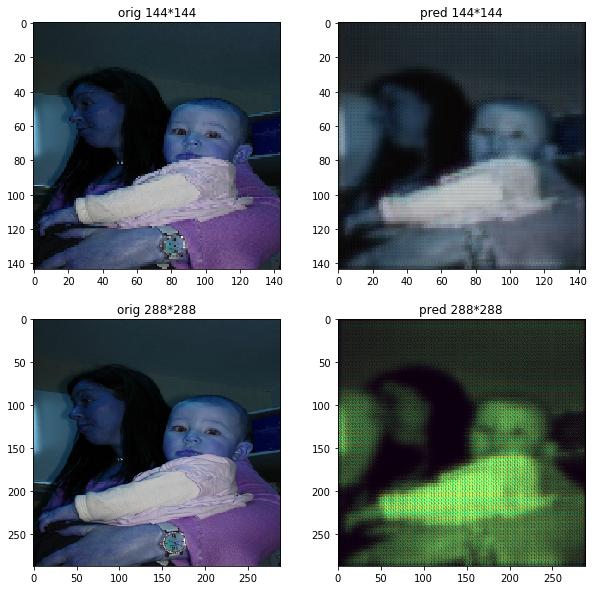

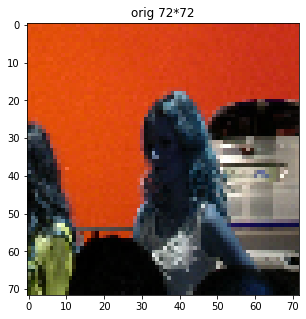

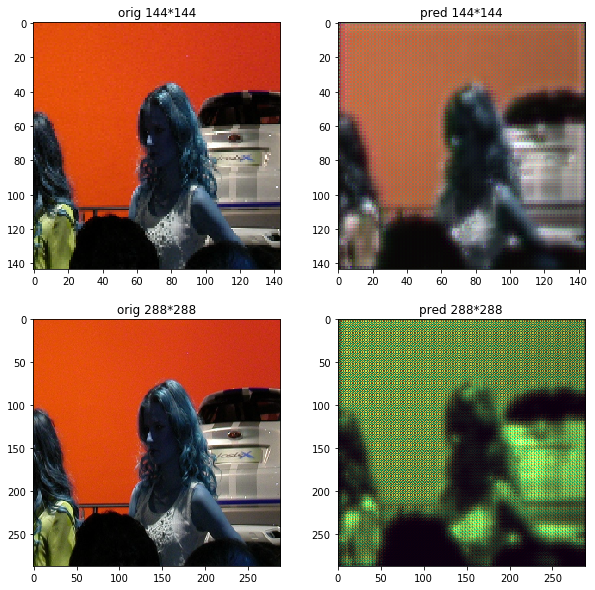

In [75]:
show_learning_history(h)
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = d2space_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = d2space_model
)

In [78]:
pre_trained_model.save_weights(join("models", "d2space.h5"))

### More residual blocks
In this model we tried to reduce the depth of our net and keep it complex. We did it by making residual blocks to layers the precede the up sampling. 

In [79]:
def create_more_res_model(weights = None):
    inp = Input(shape = (72,72,3))
    x = Conv2D(64,1)(inp)

    res_1 = res_block()(x)
    x = MaxPool2D()(res_1)

    res_2 = res_block()(x)
    x = MaxPool2D()(res_2)

    x = UpSampling2D()(x)

    x = add([x, res_2])
    x = res_block()(x)

    x = UpSampling2D()(x)
    x = add([x, res_1])

    x_144 = UpSampling2D()(x)
    x_288 = UpSampling2D(size = (4,4))(x)
    x_144 =Conv2D(3 ,1)(x_144)
    x_288 =Conv2D(3 ,1)(x_288)
    model = Model(inp, [x_144,x_288])
    if weights is None:
        return model
    else:
        model.load_weights(weights)

In [80]:
more_res_model = create_more_res_model()
more_res_model.compile(optimizer = 'adam', loss = 'mse')
more_res_model.summary()
h = train_model(more_res_model)

Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 72, 72, 64)   256         input_100[0][0]                  
__________________________________________________________________________________________________
model_88 (Model)                multiple             73856       conv2d_201[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 36, 64)   0           model_88[1][0]                   
___________________________________________________________________________________________

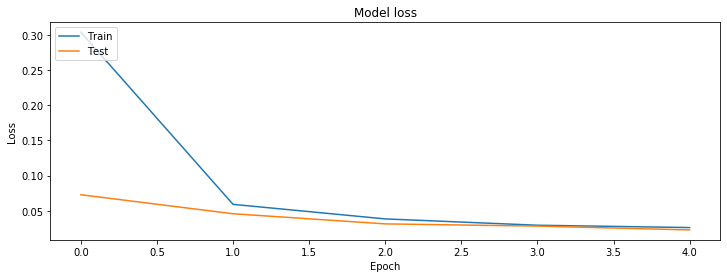

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


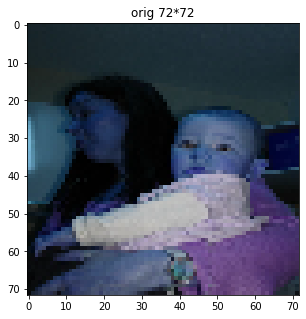

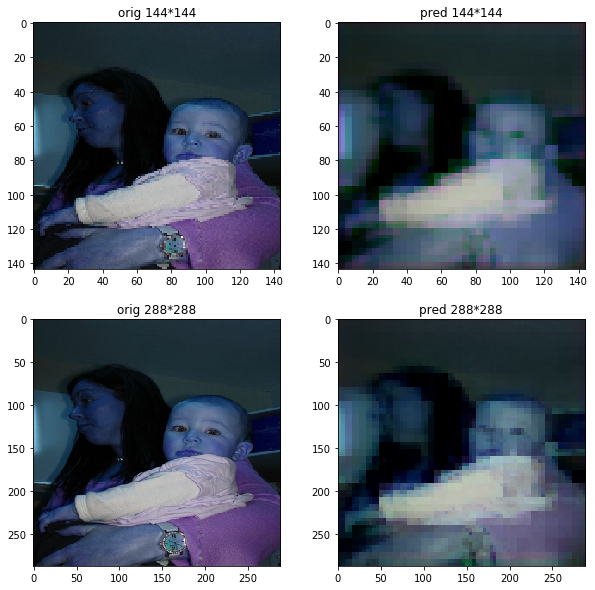

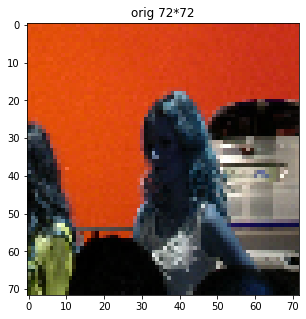

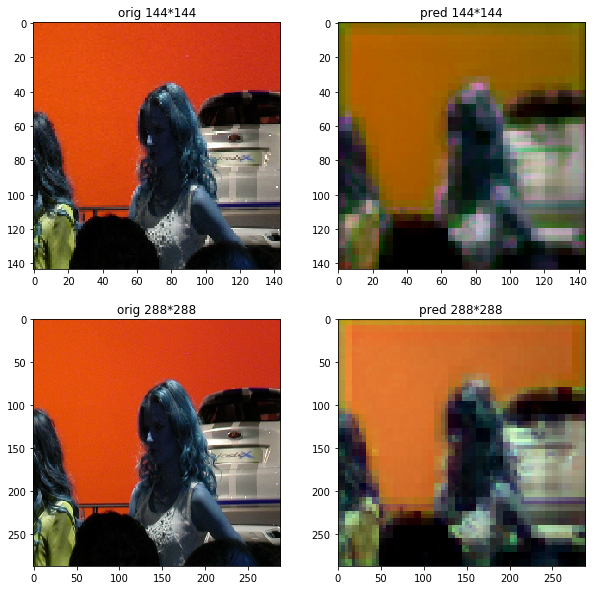

In [81]:
show_learning_history(h)
examine_model(
    idx = 0,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = more_res_model
)
examine_model(
    idx = 1,
    x = val_batch[0],
    y_144 = val_batch[1][0],
    y_288 = val_batch[1][1],
    model = more_res_model
)

In [82]:
pre_trained_model.save_weights(join("models", "more_res.h5"))

### Summary
We tried few differnt approches. It seems as the dilated convolution approach was the best considering it's not bad output and low over fitting.